In [2]:
import numpy as np
import cmasher as cmr
import matplotlib.pyplot as plt
from matplotlib.ticker import LogFormatter
import matplotlib.colors as mcolors
import cmasher as cmr

import h5py as h5
import warnings
warnings.filterwarnings('ignore')


plt.rcParams['axes.linewidth'] = 1.5
plt.rc('text', usetex=True)
plt.rc('font',**{'family':'serif','serif':['Palatino']}, size=21)

List of halos, accessed as f['Halo_0'], f['Halo_1'], etc. 

r, rho for profiles with 200 bins

nfw fit has scale density and radius

pl fit index is the third param

In [3]:
# Example

catalogue = '/scratch/hb19/gp5547/ArchivePhD/SpaxMoore/MooreL36/aout/mcdata/iso_z_12.hdf5'

f = h5.File(catalogue, 'r')
print("%d halos loaded"%len(list(f.keys())))
print(list(f.keys())[:10]) # Ordered by first digit, not sequentially 
print(list(f['Halo_0'].keys()))   
print(np.array(f['Halo_0/r']).shape)
print(np.array(f['Halo_0/rho']).shape)
print(np.array(f['Halo_0/nfw_fit']))
print(np.array(f['Halo_0/pl_fit']))

3246 halos loaded
['Halo_0', 'Halo_1', 'Halo_10', 'Halo_100', 'Halo_1000', 'Halo_1001', 'Halo_1002', 'Halo_1003', 'Halo_1004', 'Halo_1005']
['nfw_fit', 'pl_fit', 'r', 'rho']
(199,)
(199,)
[3.15765399e+09 1.50206416e-08]
[ 1.20746537e+03  2.20255982e-06 -2.80691176e+00]


In [10]:
# masses = np.array([f[k].attrs['Mass'] for k in list(f.keys())[:-1]])
# masses

## Density profiles plots

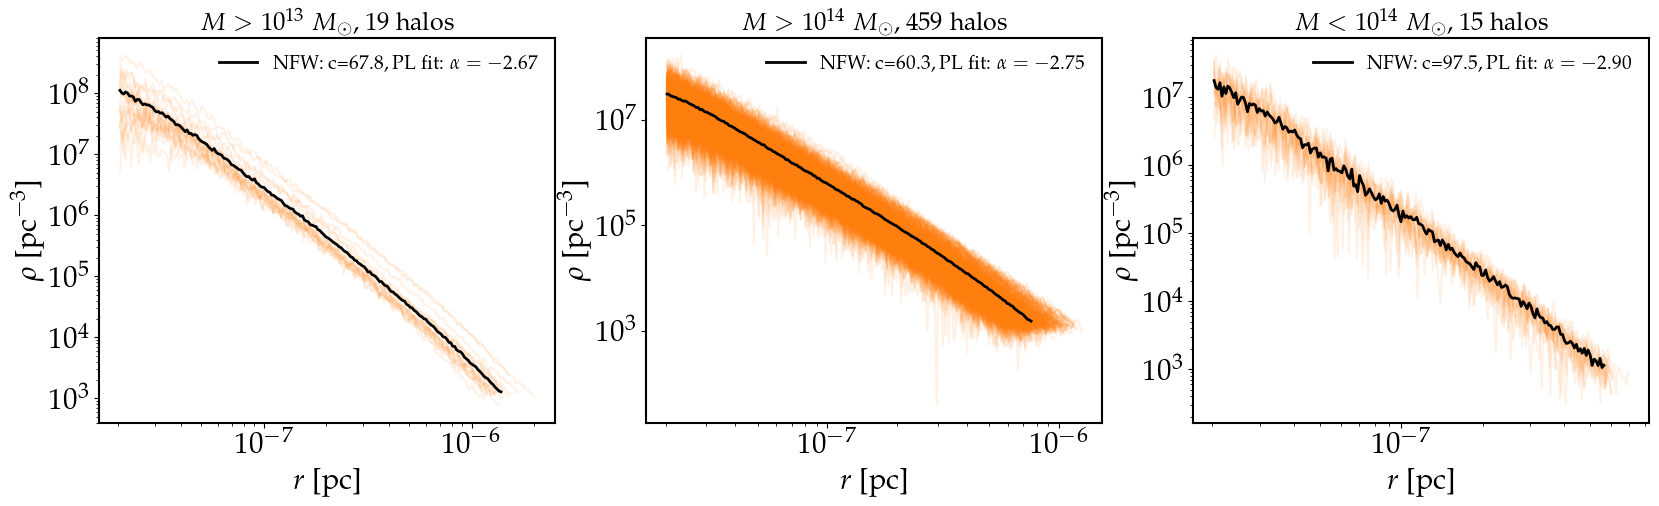

In [4]:
fig, ax = plt.subplots(1,3,figsize=(20,5))

m1, m2, m3 = [], [], []
a1, a2, a3 = [], [], []
r1, r2, r3 = [], [], []

for k in list(f.keys())[:-1]:
    mass   = f[k].attrs['Mass']
    radius = f[k].attrs['Radius']
    alpha  = f[k+'/pl_fit'][2] # PL fit rho~r^{alpha)
    rs     = f[k+'/nfw_fit'][1] # NFW scale radius
    filt   = np.array(np.where(np.array(f[k+'/rho'])==0)).size
    
    if filt > 0 or np.array(f[k+'/r'])[0]>5e-2: # Some profiles are too small or noisy and need to be filtered
        continue

    x, y = np.array(f[k+'/r']), np.array(f[k+'/rho'])
    
    if mass > 1e-13:
        ax[0].loglog(x*radius,y, c='C1', alpha=0.1)
        m1.append([x*radius, y])
        a1.append(alpha)
        r1.append(radius/rs)
    elif mass > 1e-14:
        ax[1].loglog(x*radius,y, c='C1', alpha=0.1)
        m2.append([x*radius, y])
        a2.append(alpha)
        r2.append(radius/rs)
    else:
        ax[2].loglog(x*radius,y, c='C1', alpha=0.1)
        m3.append([x*radius, y])
        a3.append(alpha)
        r3.append(radius/rs)
            

av_r_1   = np.mean(np.array(m1), axis=0)[0]
av_rho_1 = np.mean(np.array(m1), axis=0)[1]
av_r_2   = np.mean(np.array(m2), axis=0)[0]
av_rho_2 = np.mean(np.array(m2), axis=0)[1]
av_r_3   = np.mean(np.array(m3), axis=0)[0]
av_rho_3 = np.mean(np.array(m3), axis=0)[1]


ax[0].loglog(av_r_1, av_rho_1, c='k', lw=2, label=r'NFW: c=%.1f,   PL fit: $\alpha=-%.2f$'%(np.mean(r1),np.abs(np.mean(a1))))
ax[1].loglog(av_r_2, av_rho_2, c='k', lw=2, label=r'NFW: c=%.1f,   PL fit: $\alpha=-%.2f$'%(np.mean(r2),np.abs(np.mean(a2))))
ax[2].loglog(av_r_3, av_rho_3, c='k', lw=2, label=r'NFW: c=%.1f,   PL fit: $\alpha=-%.2f$'%(np.mean(r3),np.abs(np.mean(a3))))
ax[0].set_title(r'$M>10^{13}~M_{\odot}$, %d halos'%(len(m1)), fontsize=18)
ax[1].set_title(r'$M>10^{14}~M_{\odot}$, %d halos'%(len(m2)), fontsize=18)
ax[2].set_title(r'$M<10^{14}~M_{\odot}$, %d halos'%(len(m3)), fontsize=18)

for i in range(len(ax)):
    ax[i].set_xlabel(r'$r$ [pc]')
    ax[i].set_ylabel(r'$\rho $ [pc$^{-3}$]')
    ax[i].legend(frameon=False, fontsize=14)
plt.show()

## NFW and PL scatter plots

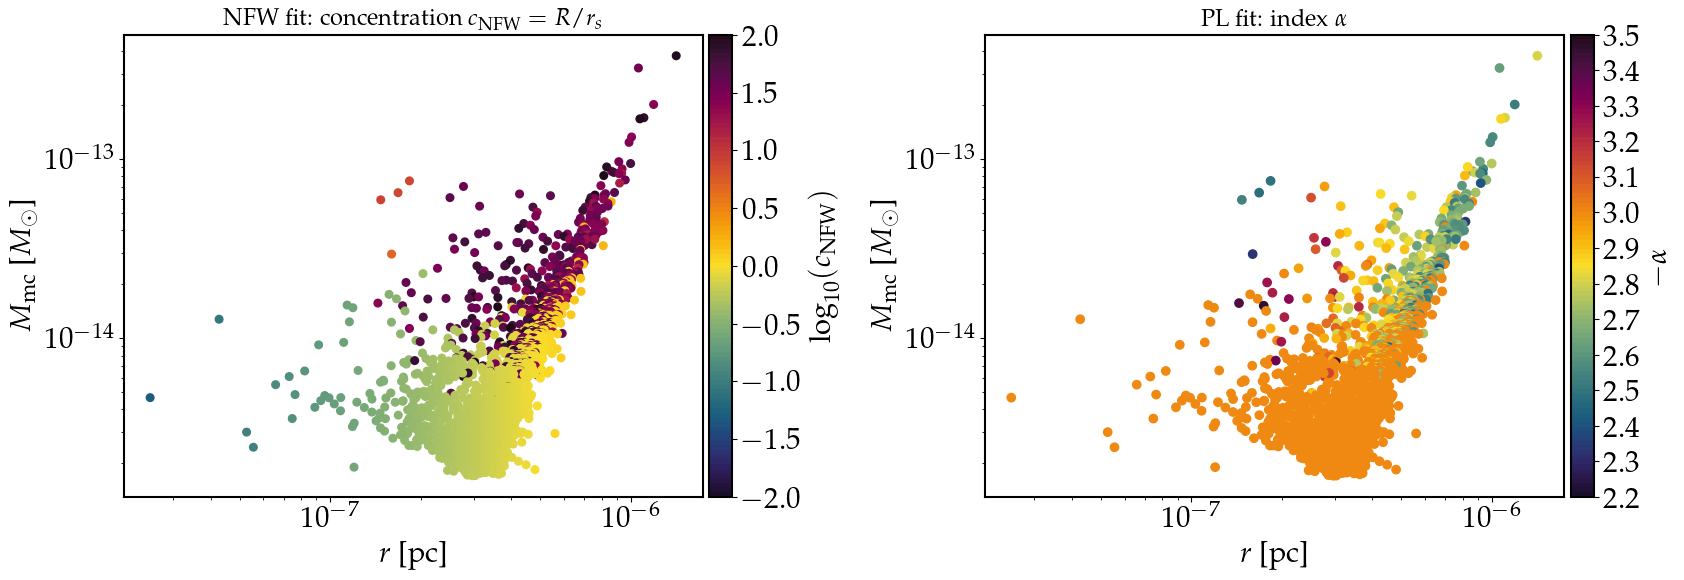

In [6]:
h = 0.7
mass = np.zeros(len(list(f.keys())[:-1]))
rads = np.zeros(len(mass))
conc = np.zeros(len(mass))
alph = np.zeros(len(mass))

for j,k in zip(range(len(mass)), (list(f.keys())[:-1])):
    mass[j] = f[k].attrs['Mass']*h
    rads[j] = f[k].attrs['Radius']*h
    conc[j] = rads[j]/f[k+'/nfw_fit'][1]
    alph[j] = -f[k+'/pl_fit'][2]


fig, ax = plt.subplots(1,2,figsize=(20,6))

tick_locations = np.arange(-2, 2.1, 0.5)
tick_labels = [r'${%.1f}$' % (t) for t in tick_locations]
colorbar_boundaries = np.geomspace(0.01, 100, 100)
norm = mcolors.LogNorm(vmin=min(colorbar_boundaries), vmax=max(colorbar_boundaries))

s1 = ax[0].scatter(rads,mass, c=conc, cmap=cmr.pride, s=30, norm=norm)
colorbar = plt.colorbar(s1, format=LogFormatter(), boundaries=colorbar_boundaries, pad=0.01)
colorbar.set_ticks(10.0**tick_locations)  # Set the tick positions as powers of 10
colorbar.set_ticklabels(tick_labels)
colorbar.set_label(r'$\log_{10}(c_{\rm NFW})$')

tick_locations = np.arange(2.2, 3.6, 0.1)
tick_labels = [r'${%.1f}$' % (t) for t in tick_locations]
colorbar_boundaries = np.linspace(2.2, 3.5, 100)
norm = mcolors.Normalize(vmin=min(colorbar_boundaries), vmax=max(colorbar_boundaries))

s2 = ax[1].scatter(rads,mass, c=alph, cmap=cmr.pride, norm=norm)
colorbar = plt.colorbar(s2, boundaries=colorbar_boundaries, pad=0.01)
colorbar.set_ticks(tick_locations)  # Set the tick positions as powers of 10
colorbar.set_ticklabels(tick_labels)
colorbar.set_label(r'$-\alpha$')


for i in range(len(ax)):
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
    ax[i].set_xlabel(r'$r$ [pc]')
    ax[i].set_ylabel(r'$M_{\rm mc}$ [$M_{\odot}$]')
ax[0].set_title(r'NFW fit: concentration $c_{\rm NFW}=R/r_s$', fontsize=17)
ax[1].set_title(r'PL fit: index $\alpha$', fontsize=17)
plt.subplots_adjust(wspace=0.25)
plt.show()